# Image Segmentation blog tutorial

## Setup Kaggle dataset, imports, and installs

In [1]:
!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!pip install kaggle
!kaggle datasets download tapakah68/supervisely-filtered-segmentation-person-dataset
!unzip supervisely-filtered-segmentation-person-dataset.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73031 sha256=3659c9373d0e03dc815c41ee0245604d50f3c7c21b1bdab595ec74bd12789f26
  Stored in directory: /root/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle
100%|█████████████████████████████████████▉| 4.31G/4.31G [01:16<00:00, 61.7MB/s]
100%|██████████████████████████████████████| 4.31G/4.31G [01:16<00:00, 60.8MB/s]
Archive:  supervisely-filtered-segmentation-person-dataset.zip
  inflating: supervisely_person_clean_2667_img/collage/ds10_pexels-photo-687782.jpg  
  inflating: supervisely_person_clean_2667_img/collage/ds10_pexels-photo-835971.jpg  
  inflating: supervisely_person_clean_2667_img/collage/ds10_pexels-photo-850708.jpg  
  inflating: supervisely_person_clean_2667_img/collage/ds10_pexels-photo-864937.jpg  
  inflating: supervisely_

In [3]:
!pip install albumentations segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 46.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=038689fcbf1b791f403bc7805dc4c955877a3e932ab0cfbac75ea5236bb12e86
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=dc0b9feadbb3c9fb2f46022c572ac33ddd07aa684143044e9e9ef192b3d86505
  Stored in directory: /root/.cache/pip/wheels/d

In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

### Seed everything helps us reproduce our work

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

## Create Segmentation Dataset

In [38]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        if is_train == True:
            x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)[:x]
        else:
            x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)[x:]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

## assign variables for training and create transforms

In [40]:
TRAIN_INP_DIR = 'supervisely_person_clean_2667_img/images/'
TRAIN_OUT_DIR = 'supervisely_person_clean_2667_img/masks/'
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 3e-4
BATCH_SIZE    = 64
NUM_EPOCHS    = 10
IMAGE_HEIGHT  = 256  
IMAGE_WIDTH   = 192  

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

## Load in the data

In [41]:
def get_loaders( inp_dir, mask_dir,batch_size,
			     train_transform, val_tranform ):
    
    train_ds     = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=False, transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

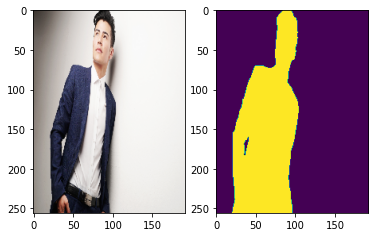

In [42]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR,
                            BATCH_SIZE,  train_transform, val_transform)
inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

## Use check_accuracy function to see how well your model performs

In [43]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

## Instantiate/download the model, loss function, and optimizer

In [44]:
model = smp.Unet(encoder_name='efficientnet-b3', in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

## Training

In [45]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [46]:
check_accuracy(val_loader, model, device=DEVICE)


100%|██████████| 9/9 [00:40<00:00,  4.52s/it]

Got 8571613/26198016 with pixel accuracy 32.72
Dice score: 46.95


In [47]:
for epoch in range(NUM_EPOCHS):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    
    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

########################## epoch: 0


100%|██████████| 9/9 [00:32<00:00,  3.56s/it]


Got 24512857/26198016 with pixel accuracy 93.57
Dice score: 89.34
########################## epoch: 1


  0%|          | 0/34 [00:01<?, ?it/s]


KeyboardInterrupt: 

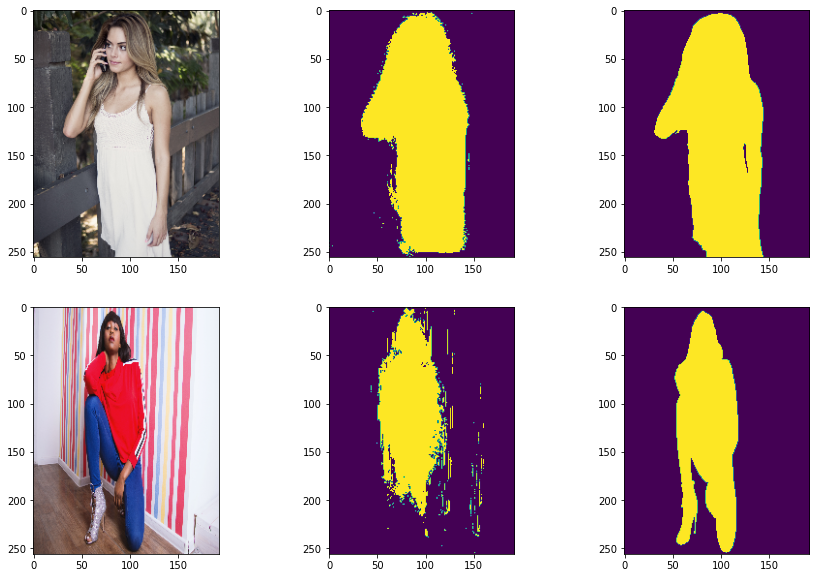

In [48]:
inputs, masks = next(iter(val_loader))
output        = ((torch.sigmoid(model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(15,10))
for k in range(2):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])